In [2]:
import numpy as np
import os
import pickle
import nibabel as nib
import pandas as pd
import h5py
import matplotlib.pyplot as plt

In [17]:
def time_interval_split(meta_path=None, save_file=False, setting_save_path=None, meta_csv_path=None):
    """
    Function: Select time points with image presentation in design matrix
    ----------------
    Input:
    meta_path: path to a set of design matrices
    save_file: True if the output is needed to be stored offline
    setting_save_path: the path to store the output
    meta_csv_path: the path for reading the meta csv doc containing image information
    ----------------
    Output:
    des_store: a file containing dict of time points with image at each run
    """
    assert os.path.isdir(meta_path), 'Invalid design matrix!'
    
    if meta_csv_path:
        import pandas as pd
        csv_file = pd.read_csv(meta_csv_path, index_col=0)
    
    des_store = {}
    for design_matrix_path in os.listdir(meta_path):
        file_path = os.path.join(meta_path, design_matrix_path)
        des_file = np.genfromtxt(file_path, delimiter='\t')
        img_idx = des_file[np.nonzero(des_file)].tolist()
        if meta_csv_path:
            share_1000 = csv_file.loc[np.array(img_idx, dtype=int)-1]['shared1000']
            cocoid = csv_file.loc[np.array(img_idx, dtype=int)-1]['cocoId']
            cocosplit = csv_file.loc[np.array(img_idx, dtype=int)-1]['cocoSplit']
        time_points = [i for i, val in enumerate(des_file) if val]
        if not img_idx:
            des_store[design_matrix_path[-19:-4]] = ['rs_fmri']
        elif meta_csv_path:
            des_store[design_matrix_path[-19:-4]] = [time_points, np.array(img_idx, dtype=int)-1, np.array(cocoid.tolist(), dtype=int), cocosplit.tolist(), np.array(share_1000.tolist())]
        else:
            des_store[design_matrix_path[-19:-4]] = [time_points, np.array(img_idx, dtype=int)-1]
    
    if save_file:
        meta_mt_path, design_meta_path = os.path.split(meta_path)
        if not setting_save_path:
            new_path = os.path.join(meta_mt_path, 'selected_design_matrix')
        else:
            new_path = setting_save_path
        if not os.path.isdir(new_path):
            os.mkdir(new_path)
        new_file = os.path.join(new_path, 'selected_design_matrix.pkl')
        with open(new_file, 'wb') as f:
            pickle.dump(des_store, f)
    
    return des_store

In [18]:
meta_path = 'design/s1'
csv_path = 'experiments/nsd_stim_info_merged.csv'
save_path = 'selected_design_new/s1'
des_store = time_interval_split(meta_path, save_file=True, setting_save_path=save_path, meta_csv_path=csv_path)

In [26]:
des_store['session01_run05'][3]

['train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'val2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'val2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017',
 'train2017']

In [2]:
def fmri_split(meta_path=None, design_matrix=None, save_file=False, split=1, setting_save_path=None, setting_test_path=None):
    """
    Function: Split fmri image (3D) data with processed design matrix
    -------------------
    Input:
    meta_path: path to a set of nii.gz file from NSD dataset
    design_matrix: either path to processed design matrix or file
    save_file: True to save the output
    setting_save_path: the path to store the output
    -------------------
    Output:
    fmri_store: a list containing all fmri with image presentation
    """
    assert os.path.isdir(meta_path), 'Invalid fmri data path!'
    
    if isinstance(design_matrix, dict):
        des_mat = design_matrix
    elif os.path.isfile(design_matrix):
        with open(design_matrix, 'rb') as f:
            des_mat = pickle.load(f)
    else:
        raise Exception('Unknown design matrix')
    
    fmri_store = []
    test_store = []
    session_count = int(os.listdir(meta_path)[-1][-15:-13])
    split_patch = session_count // split
    split_count = 1
    
    for sub_file in sorted(os.listdir(meta_path)):
        if str(split_patch*split_count+1) in sub_file[-22:-13]:
            print('------Split {} Finished-------'.format(split_count))
            if save_file:
                print('Saving File for Split {}...'.format(split_count))
                meta_mt_path, fmri_meta = os.path.split(meta_path)
                if not setting_save_path:
                    new_path = os.path.join(meta_mt_path, 'selected_fmri')
                else:
                    new_path = setting_save_path
                if not os.path.isdir(new_path):
                    os.mkdir(new_path)
                new_file = os.path.join(new_path, 'selected_fmri_'+str(split_count)+'.pkl')
                with open(new_file, 'wb') as f:
                    pickle.dump(np.concatenate(fmri_store, axis=0), f)
            split_count += 1
            del fmri_store
            fmri_store = []
    
        print('---FMRI_SPLIT: PROCESSING {}------'.format(sub_file))
        fmri_file_path = os.path.join(meta_path, sub_file)
        fmri_file = nib.load(fmri_file_path)
        fmri_array = np.transpose(fmri_file.get_fdata(), (-1, 0, 1, 2))
        del fmri_file
        time_points = des_mat[sub_file[-22:-7]][0]
        share1000 = des_mat[sub_file[-22:-7]][-1]
        if time_points == 'rs_fmri':
            continue
        fmri_select = fmri_array[time_points]
        del fmri_array
        fmri_train_val = fmri_select[~share1000]
        fmri_test = fmri_select[share1000]
        del fmri_select
        fmri_store.append(fmri_train_val)
        del fmri_train_val
        test_store.append(fmri_test)
        del fmri_test
        
    if save_file:
        print('Saving File for Split {}...'.format(split_count))
        meta_mt_path, fmri_meta = os.path.split(meta_path)
        if not setting_save_path:
            new_path = os.path.join(meta_mt_path, 'selected_fmri')
        else:
            new_path = setting_save_path
        if not os.path.isdir(new_path):
            os.mkdir(new_path)
        new_file = os.path.join(new_path, 'selected_fmri_'+str(split_count)+'.pkl')
        with open(new_file, 'wb') as f:
            pickle.dump(np.concatenate(fmri_store, axis=0), f)
        del fmri_store
        if not setting_test_path:
            test_path = new_path
        else:
            test_path = setting_test_path
        test_file = os.path.join(test_path, 'test.pkl')
        print('Saving Test File')
        with open(test_file, 'wb') as f:
            pickle.dump(np.concatenate(test_store, axis=0), f)
    
    print('Done!')
    
    return test_store

In [3]:
meta_path = '/media/huhaoyu/My Passport/NSD_data/time_series/s1'
save_path = '/media/huhaoyu/My Passport/NSD_data/processed_data/select_fmri_new/s1'
test_path = '/media/huhaoyu/My Passport/NSD_data/processed_data/test_fmri/s1'
design_matrix = '/media/huhaoyu/My Passport/NSD_data/processed_data/selected_design_new/s1/selected_design_matrix.pkl'
test_store = fmri_split(meta_path, design_matrix=design_matrix, split=20, save_file=True, setting_save_path=save_path, setting_test_path=test_path)

---FMRI_SPLIT: PROCESSING timeseries_session01_run01.nii.gz------
---FMRI_SPLIT: PROCESSING timeseries_session01_run02.nii.gz------
---FMRI_SPLIT: PROCESSING timeseries_session01_run03.nii.gz------
---FMRI_SPLIT: PROCESSING timeseries_session01_run04.nii.gz------
---FMRI_SPLIT: PROCESSING timeseries_session01_run05.nii.gz------
---FMRI_SPLIT: PROCESSING timeseries_session01_run06.nii.gz------
---FMRI_SPLIT: PROCESSING timeseries_session01_run07.nii.gz------
---FMRI_SPLIT: PROCESSING timeseries_session01_run08.nii.gz------
---FMRI_SPLIT: PROCESSING timeseries_session01_run09.nii.gz------
---FMRI_SPLIT: PROCESSING timeseries_session01_run10.nii.gz------
---FMRI_SPLIT: PROCESSING timeseries_session01_run11.nii.gz------
---FMRI_SPLIT: PROCESSING timeseries_session01_run12.nii.gz------
---FMRI_SPLIT: PROCESSING timeseries_session02_run01.nii.gz------
---FMRI_SPLIT: PROCESSING timeseries_session02_run02.nii.gz------
---FMRI_SPLIT: PROCESSING timeseries_session02_run03.nii.gz------
---FMRI_SP

In [12]:
def find_img(img_path=None, design_matrix=None, annot_set=None, split=1, save_file=False, setting_save_path=None, setting_test_path=None):
    """
    Function: locate corresponding images according to processed design matrix
    ----------------------
    Input:
    img_path: path to the hdf5 file storing images (nsd_stimuli.hdf5)
    design_matrix: processed design matrix by function 'time_interval_split' or the path to it
    ------------------------
    Output:
    img_list: a list of image selected, in which the first element is the image set, the second is whether it belongs to shared1000 set
    """
    
    assert os.path.isfile(img_path), 'Invalid NSD Experiment Image File Path'
    
    if isinstance(design_matrix, dict):
        des_mat = design_matrix
    elif os.path.isfile(design_matrix):
        with open(design_matrix, 'rb') as f:
            des_mat = pickle.load(f)
    else:
        raise Exception('Unknown design matrix')
    
    if annot_set:
        from pycocotools.coco import COCO
        coco_train = COCO(annot_set[0])
        coco_val = COCO(annot_set[1])
    
    img_store = []
    test_store = []
    annot = []
    annot_test = []
    session_count = int(list(des_mat.keys())[-1][-8:-6])
    split_patch = session_count // split
    split_count = 1
    
    for sub_file in sorted(list(des_mat.keys())):
        if str(split_patch*split_count+1) in sub_file[:-6]:
            print('------Split {} Finished-------'.format(split_count))
            if save_file:
                print('Saving File for Split {}...'.format(split_count))
                img_meta, img_file = os.path.split(img_path)
                if not setting_save_path:
                    new_path = os.path.join(img_meta, 'selected_img')
                else:
                    new_path = setting_save_path
                if not os.path.isdir(new_path):
                    os.mkdir(new_path)
                new_file = os.path.join(new_path, 'selected_img_'+str(split_count)+'.pkl')
                with open(new_file, 'wb') as f:
                    pickle.dump(np.concatenate(img_store, axis=0), f)
                if annot_set:
                    ann_file = os.path.join(annot_set[2], 'selected_annot_'+str(split_count)+'.pkl')
                    with open(ann_file, 'wb') as f:
                        pickle.dump(annot, f)
            split_count += 1
            del img_store
            img_store = []
    
        print('---FIND_IMAGE: PROCESSING {}------'.format(sub_file))
        share1000 = des_mat[sub_file][-1]
        if des_mat[sub_file][0] == 'rs_fmri':
            continue
        img_idx = des_mat[sub_file][1]
        cocoid = des_mat[sub_file][2]
        cocosplit = des_mat[sub_file][3]
        with h5py.File(img_path, 'r') as img_set:
            img_select = []
            annot_select = []
            for idx_count, idx_img in enumerate(img_idx):
                img_select.append(img_set['imgBrick'][idx_img])
                if annot_set:
                    coco_id = cocoid[idx_count]
                    coco_split = cocosplit[idx_count]
                    if 'train' in coco_split:
                        annIds = coco_train.getAnnIds(imgIds=coco_id)
                        anns = coco_train.loadAnns(annIds)
                        annot_select.append(anns)
                    else:
                        annIds = coco_val.getAnnIds(imgIds=coco_id)
                        anns = coco_val.loadAnns(annIds)
                        annot_select.append(anns)
            img_select = np.stack(img_select, axis=0)
            img_train_val = img_select[~share1000]
            img_test = img_select[share1000]
            del img_select
            img_store.append(img_train_val)
            del img_train_val
            test_store.append(img_test)
            del img_test
            if annot_set:
                ann_train_val = [annot_select[i] for i, val in enumerate(~share1000) if val]
                ann_test = [annot_select[i] for i, val in enumerate(share1000) if val]
                annot += ann_train_val
                annot_test += ann_test
        
    if save_file:
        print('Saving File for Split {}...'.format(split_count))
        img_meta, img_file = os.path.split(img_path)
        if not setting_save_path:
            new_path = os.path.join(img_meta, 'selected_img')
        else:
            new_path = setting_save_path
        if not os.path.isdir(new_path):
            os.mkdir(new_path)
        new_file = os.path.join(new_path, 'selected_img_'+str(split_count)+'.pkl')
        with open(new_file, 'wb') as f:
            pickle.dump(np.concatenate(img_store, axis=0), f)
        if annot_set:
            ann_file = os.path.join(annot_set[2], 'selected_annot_'+str(split_count)+'.pkl')
            with open(ann_file, 'wb') as f:
                pickle.dump(annot, f)
            ann_test_file = os.path.join(annot_set[3], 'test.pkl')
            with open(ann_test_file, 'wb') as f:
                pickle.dump(annot_test, f)
        if not setting_test_path:
            test_path = new_path
        else:
            test_path = setting_test_path
        test_file = os.path.join(test_path, 'test.pkl')
        print('Saving Test File')
        with open(test_file, 'wb') as f:
            pickle.dump(np.concatenate(test_store, axis=0), f)
    
    print('Done!')
    
    return img_store, test_store

In [13]:
img_path = '/media/huhaoyu/My Passport/NSD_data/img/nsd_stimuli.hdf5'
save_path = '/media/huhaoyu/My Passport/NSD_data/processed_data/selected_img_new/s1'
test_path = '/media/huhaoyu/My Passport/NSD_data/processed_data/test_img/s1'
design_matrix = '/media/huhaoyu/My Passport/NSD_data/processed_data/selected_design_new/s1/selected_design_matrix.pkl'
annot_set = ('/media/huhaoyu/My Passport/NSD_data/annotations/captions_train2017.json', '/media/huhaoyu/My Passport/NSD_data/annotations/captions_val2017.json'
             , '/media/huhaoyu/My Passport/NSD_data/processed_data/selected_annot_new/s1', '/media/huhaoyu/My Passport/NSD_data/processed_data/test_annot/s1')
img_store, test_store = find_img(img_path, design_matrix=design_matrix, annot_set=annot_set, split=20, save_file=True, setting_save_path=save_path, setting_test_path=test_path)

loading annotations into memory...
Done (t=0.78s)
creating index...
index created!
loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
---FIND_IMAGE: PROCESSING session01_run01------
---FIND_IMAGE: PROCESSING session01_run02------
---FIND_IMAGE: PROCESSING session01_run03------
---FIND_IMAGE: PROCESSING session01_run04------
---FIND_IMAGE: PROCESSING session01_run05------
---FIND_IMAGE: PROCESSING session01_run06------
---FIND_IMAGE: PROCESSING session01_run07------
---FIND_IMAGE: PROCESSING session01_run08------
---FIND_IMAGE: PROCESSING session01_run09------
---FIND_IMAGE: PROCESSING session01_run10------
---FIND_IMAGE: PROCESSING session01_run11------
---FIND_IMAGE: PROCESSING session01_run12------
---FIND_IMAGE: PROCESSING session02_run01------
---FIND_IMAGE: PROCESSING session02_run02------
---FIND_IMAGE: PROCESSING session02_run03------
---FIND_IMAGE: PROCESSING session02_run04------
---FIND_IMAGE: PROCESSING session02_run05------
---FIND_IMAGE: PRO

In [24]:
def data_integration(fmri_path=None, img_path=None, capt_path=None, save_path=None, split=True):
    """
    """
    fmri_file = sorted(os.listdir(fmri_path))
    img_file = sorted(os.listdir(img_path))
    capt_file = sorted(os.listdir(capt_path))

    if not split:
        store_list = []

    for idx_file in range(len(fmri_file)):
        print('Integrating {}, {}, {}'.format(fmri_file[idx_file], img_file[idx_file], capt_file[idx_file]))
        if split:
            store_list = []

        with open(os.path.join(fmri_path, fmri_file[idx_file]), 'rb') as f:
            fmri = pickle.load(f)
        with open(os.path.join(img_path, img_file[idx_file]), 'rb') as f:
            img = pickle.load(f)
        with open(os.path.join(capt_path, capt_file[idx_file]), 'rb') as f:
            capt = pickle.load(f)
        
        for idx_in_file in range(fmri.shape[0]):
            store_dict = {}
            store_dict['fmri'] = fmri[idx_in_file]
            store_dict['image'] = img[idx_in_file]
            store_dict['caption'] = capt[idx_in_file]
            store_list.append(store_dict)
    
        if split:
            print('Saving File for Split {}'.format(str(idx_file+1)))
            save_file = os.path.join(save_path, 'integrated_data_'+str(idx_file+1)+'.pkl')
            with open(save_file, 'wb') as f:
                pickle.dump(store_list, f)
    if not split:
        print('Saving Integrated Data as a single file')
        save_file = os.path.join(save_path, 'integrated_data_only.pkl')
        with open(save_file, 'wb') as f:
            pickle.dump(store_list, f)
    print('Done!')

    return 1

In [19]:
fmri_path = '/media/huhaoyu/My Passport/NSD_data/processed_data/select_fmri_new/s1'
img_path = '/media/huhaoyu/My Passport/NSD_data/processed_data/selected_img_new/s1'
capt_path = '/media/huhaoyu/My Passport/NSD_data/processed_data/selected_annot_new/s1'
save_path = '/media/huhaoyu/My Passport/NSD_data/processed_data/train_val_data/s1'
data_integration(fmri_path, img_path, capt_path, save_path, split=True)

Integrating selected_fmri_1.pkl, selected_img_1.pkl, selected_annot_1.pkl
Saving File for Split 1
Integrating selected_fmri_2.pkl, selected_img_2.pkl, selected_annot_2.pkl
Saving File for Split 2
Integrating selected_fmri_3.pkl, selected_img_3.pkl, selected_annot_3.pkl
Saving File for Split 3
Integrating selected_fmri_4.pkl, selected_img_4.pkl, selected_annot_4.pkl
Saving File for Split 4
Integrating selected_fmri_5.pkl, selected_img_5.pkl, selected_annot_5.pkl
Saving File for Split 5
Integrating selected_fmri_6.pkl, selected_img_6.pkl, selected_annot_6.pkl
Saving File for Split 6
Integrating selected_fmri_7.pkl, selected_img_7.pkl, selected_annot_7.pkl
Saving File for Split 7
Integrating selected_fmri_8.pkl, selected_img_8.pkl, selected_annot_8.pkl
Saving File for Split 8
Integrating selected_fmri_9.pkl, selected_img_9.pkl, selected_annot_9.pkl
Saving File for Split 9
Integrating selected_fmri_10.pkl, selected_img_10.pkl, selected_annot_10.pkl
Saving File for Split 10
Integrating sele

1

In [25]:
fmri_path = '/media/huhaoyu/My Passport/NSD_data/processed_data/test_fmri/s1'
img_path = '/media/huhaoyu/My Passport/NSD_data/processed_data/test_img/s1'
capt_path = '/media/huhaoyu/My Passport/NSD_data/processed_data/test_annot/s1'
save_path = '/media/huhaoyu/My Passport/NSD_data/processed_data/test_data/s1'
data_integration(fmri_path, img_path, capt_path, save_path, split=True)

Integrating test.pkl, test.pkl, test.pkl
Saving File for Split 1
Done!


1

In [20]:
temp_path = '/media/huhaoyu/My Passport/NSD_data/processed_data/train_val_data/s1/integrated_data_20.pkl'
with open(temp_path, 'rb') as f:
    temp = pickle.load(f)

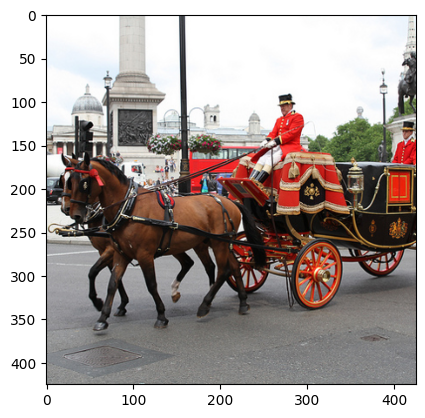

In [21]:
plt.imshow(temp[1000]['image'])

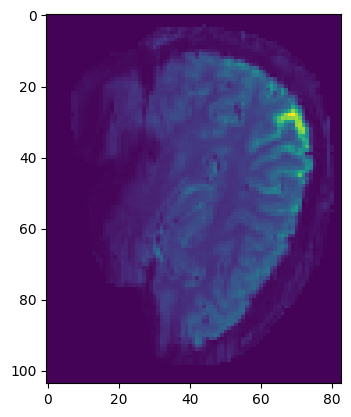

In [15]:
plt.imshow(temp[0]['fmri'][20,:,:])

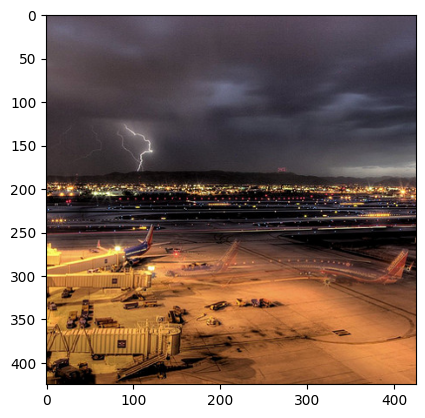

In [22]:
plt.imshow(temp[1]['image'])

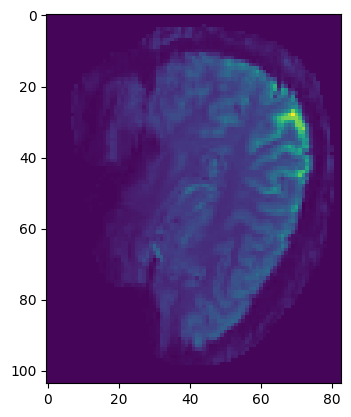

In [5]:
plt.imshow(temp[1]['fmri'][20,:,:])

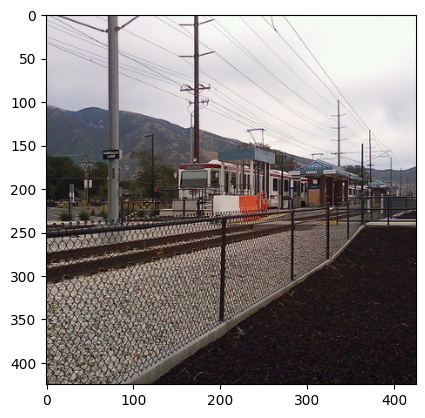

In [23]:
plt.imshow(temp[2]['image'])

In [10]:
temp_img_path = '/media/huhaoyu/My Passport/NSD_data/processed_data/selected_img_new/s1/selected_img_1.pkl'
with open(temp_img_path, 'rb') as f:
    temp_img = pickle.load(f)

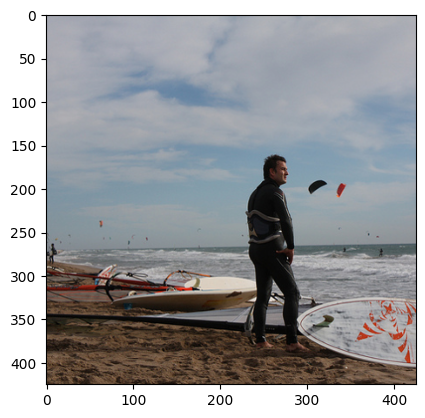

In [11]:
plt.imshow(temp_img[0])

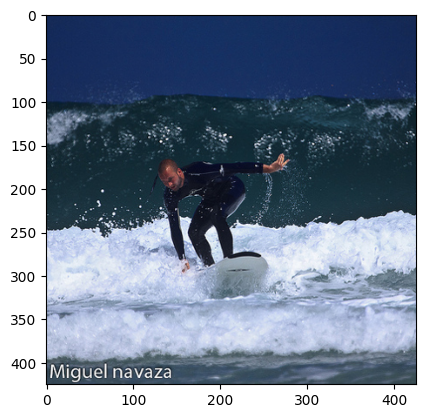

In [12]:
plt.imshow(temp_img[1])